# LIBRERIAS

In [36]:
# CARGAR LIBRERIAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# DATOS

URL = https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

**Context**

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

**Attribute Information**

1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [2]:
# CARGAR BASE DE DATOS

df = pd.read_csv('../BBDD/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# ANALISIS EXPLORATORIO DE DATOS

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# BORRAR COLUMNA ID

df.drop(columns='id', inplace=True)

In [5]:
# COMPROBAR NANS Y SUS PORCENTAJES

print(df.isnull().sum())
print()
print(df.isnull().sum() / len(df) * 100)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


In [6]:
# COMPROBAR DUPLICADOS

df.duplicated().sum()

0

In [7]:
# ESTADISTICOS DEL DATAFRAME

round(df.describe(include='all'), 2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.00,5110.0,5110.00,5110,5110,5110,5110.00,4909.00,5110,5110.00
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,NaN,43.23,0.1,0.05,NaN,NaN,NaN,106.15,28.89,NaN,0.05
std,NaN,22.61,0.3,0.23,NaN,NaN,NaN,45.28,7.85,NaN,0.22
min,NaN,0.08,0.0,0.00,NaN,NaN,NaN,55.12,10.30,NaN,0.00
25%,NaN,25.00,0.0,0.00,NaN,NaN,NaN,77.24,23.50,NaN,0.00
50%,NaN,45.00,0.0,0.00,NaN,NaN,NaN,91.88,28.10,NaN,0.00
75%,NaN,61.00,0.0,0.00,NaN,NaN,NaN,114.09,33.10,NaN,0.00


In [8]:
# LISTA DE COLUMNAS

df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

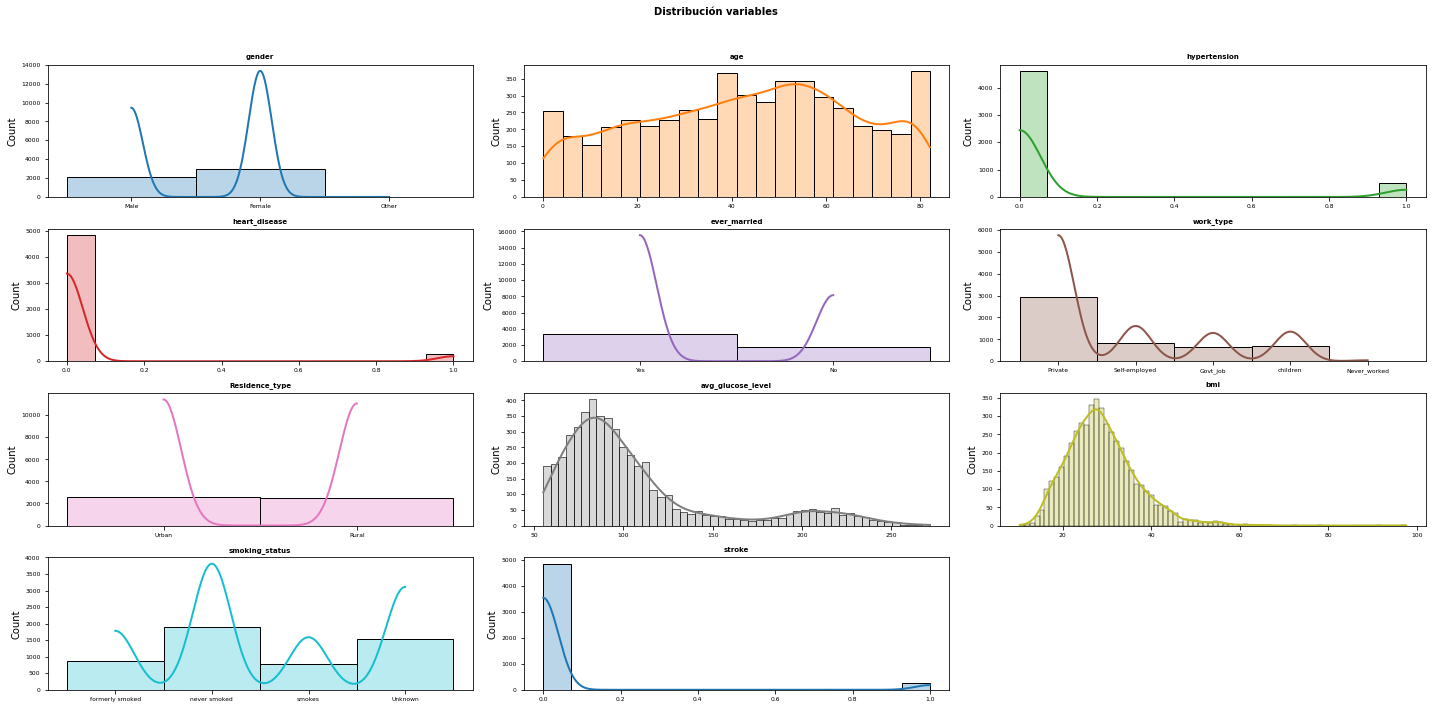

In [9]:
# DISTRIBUCION DE LAS VARIABLES

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 10))
axes = axes.flat
columnas = df.columns

for i, col in enumerate(columnas):
    
    sns.histplot(
        data=df,
        x=col,
        stat="count",
        kde=True,
        color=(list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws={'linewidth': 2},
        alpha= 0.3,
        ax=axes[i]
    )
    
    axes[i].set_title(col, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.delaxes(axes[11]) # BORRAR FIGURA EN POSICION 11
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables', fontsize=10, fontweight="bold");

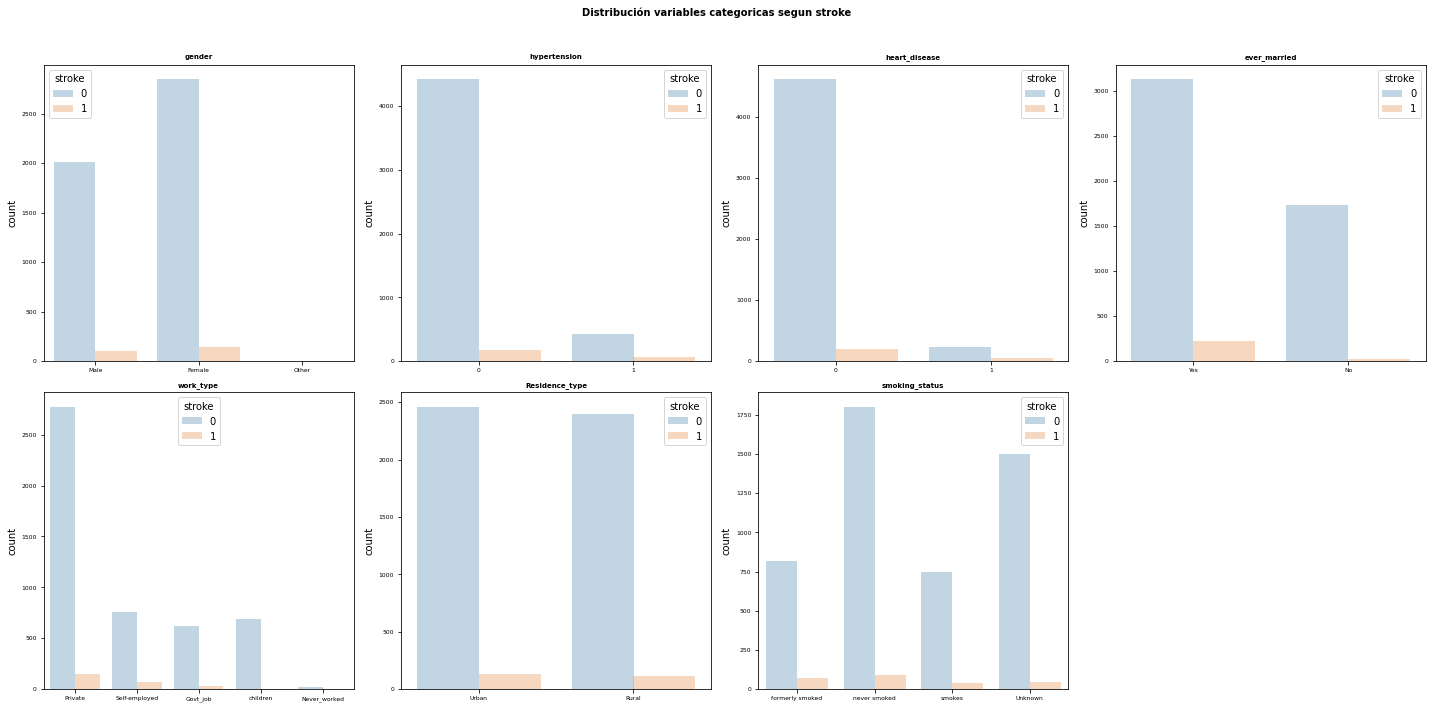

In [10]:
# DISTRIBUCION DE STROKE CON VARIABLES CATEGORICAS

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flat
columnas = df[['gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status']]

for i, col in enumerate(columnas):
    
    sns.countplot(
        data=df,
        x=col,
        hue='stroke',
        alpha= 0.3,
        ax=axes[i]
    )
    
    axes[i].set_title(col, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
   
fig.delaxes(axes[7]) # BORRAR FIGURA EN POSICION 7

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables categoricas segun stroke', fontsize=10, fontweight="bold");

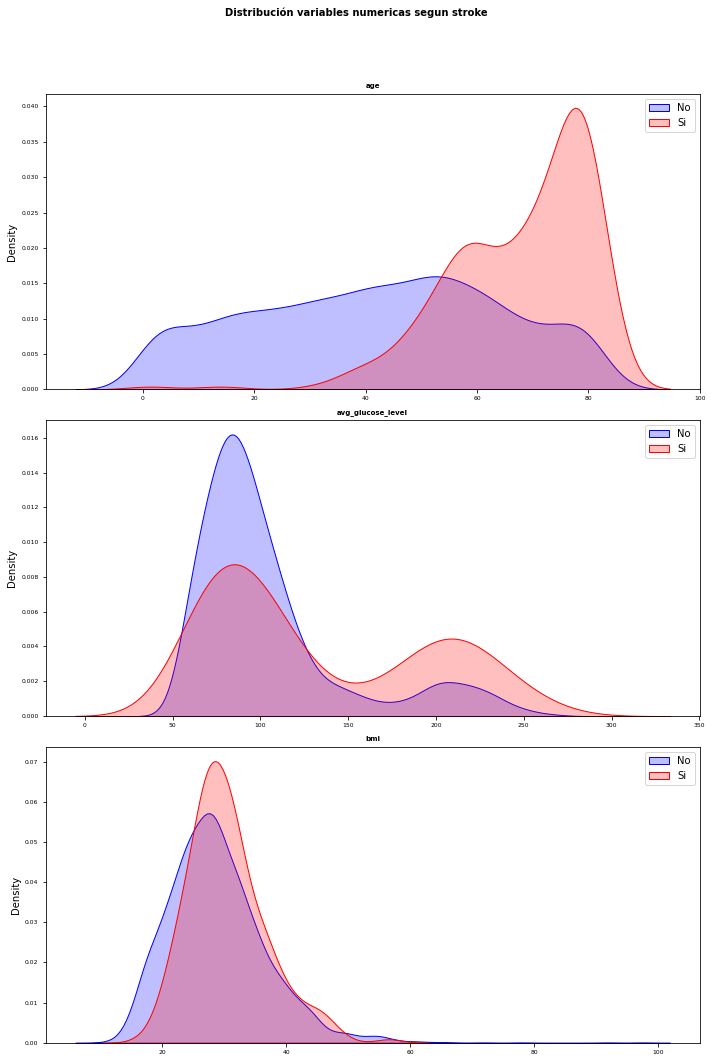

In [11]:
# DISTRIBUCION DE STROKE CON VARIABLES NUMERICAS

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
axes = axes.flat
columnas = df[['age', 'avg_glucose_level', 'bmi']]

for i, col in enumerate(columnas):
    
    sns.kdeplot(columnas[col][(df['stroke'] == 0)], color='blue', shade=True, ax=axes[i])
    sns.kdeplot(df[col][(df['stroke'] == 1)], color='red', shade=True, ax=axes[i])
    axes[i].set_title(col, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].legend(['No', 'Si'])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numericas segun stroke', fontsize=10, fontweight="bold");

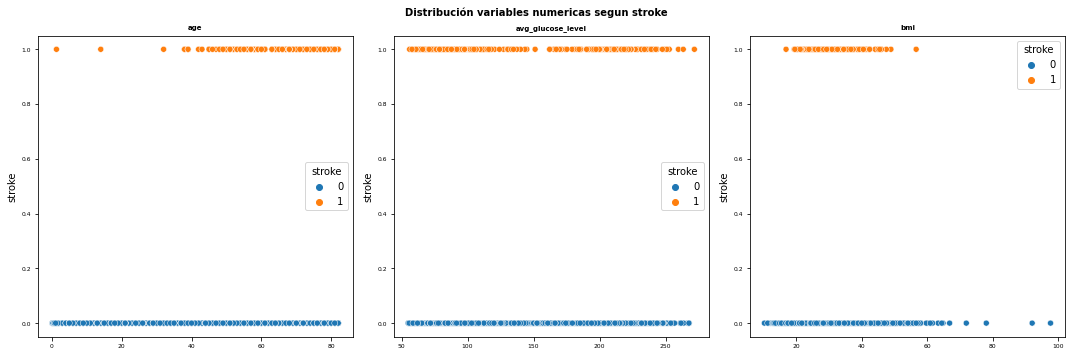

In [12]:
# CORRELACION DE STROKE CON VARIABLES NUMERICAS

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flat
columnas = df[['age', 'avg_glucose_level', 'bmi']]

for i, col in enumerate(columnas):
    
    sns.scatterplot(columnas[col], df['stroke'], hue=df['stroke'], ax=axes[i])
    axes[i].set_title(col, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numericas segun stroke', fontsize=10, fontweight="bold");

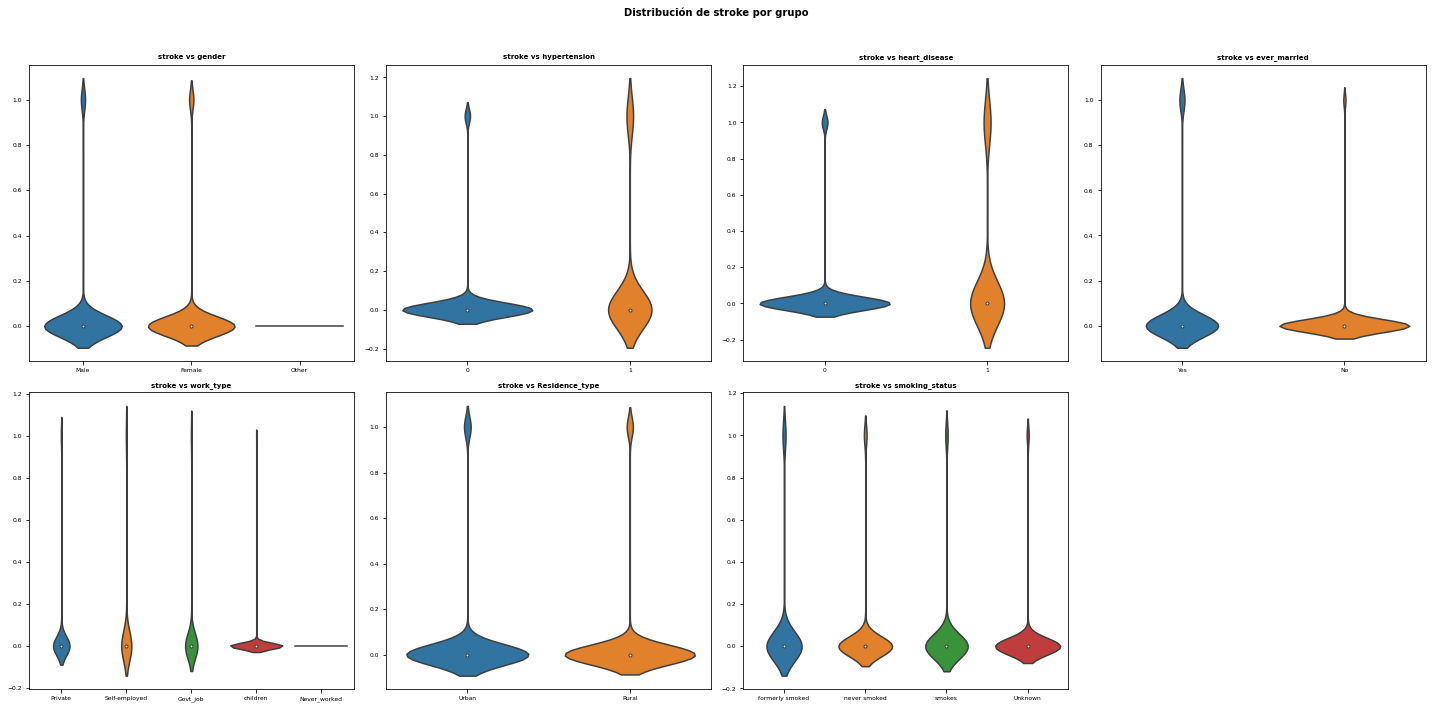

In [13]:
# DISTRIBUCION DE STROKE CON VARIABLES CATEGORICAS

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flat
columnas = df[['gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status']]

for i, col in enumerate(columnas):
    
    sns.violinplot(
        x=col,
        y='stroke',
        data=df,
        ax=axes[i]
)
    
    axes[i].set_title(f"stroke vs {col}", fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.delaxes(axes[7]) # BORRAR FIGURA EN POSICION 7

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de stroke por grupo', fontsize=10, fontweight="bold");

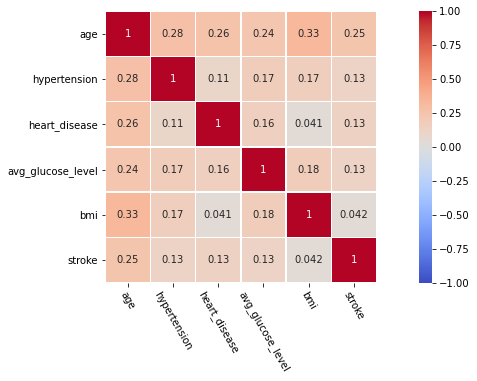

In [14]:
# CORRELACION DE LAS VARIABLES

plt.figure(figsize=(15, 5))
sns.heatmap(df.corr(),
           vmin=-1,
           vmax=1,
           cmap=sns.color_palette("coolwarm", as_cmap=True),
           square=True,
           linewidths=0.5,
           annot=True)

plt.xticks(rotation=-60);

# PREPROCESADO DE DATOS

In [15]:
# TOTAL DE MISSINGS EN STROKE = 1

print(df[df['stroke'] == 1].count())
print()
print(df[df['stroke'] == 1].isnull().sum())

gender               249
age                  249
hypertension         249
heart_disease        249
ever_married         249
work_type            249
Residence_type       249
avg_glucose_level    249
bmi                  209
smoking_status       249
stroke               249
dtype: int64

gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  40
smoking_status        0
stroke                0
dtype: int64


In [16]:
# SUSTITUIR EN COLUMNA 'GENDER' FEMALE POR 0 Y MALE POR 1

df.loc[df['gender'] == 'Female', 'gender'] = 0
df.loc[df['gender'] == 'Male', 'gender'] = 1

# SUSTITUIR EN COLUMNA 'EVER_MARRIED' NO POR 0 Y YES POR 1

df.loc[df['ever_married'] == 'No', 'ever_married'] = 0
df.loc[df['ever_married'] == 'Yes', 'ever_married'] = 1

# SUSTITUIR EN COLUMNA 'RESIDENCE TYPE' RURAL POR 0 Y URBAN POR 1

df.loc[df['Residence_type'] == 'Rural', 'Residence_type'] = 0
df.loc[df['Residence_type'] == 'Urban', 'Residence_type'] = 1

In [17]:
# COMPROBAR CON UNA MASCARA SI HAY ALGUNA FILA CON GENDER 'OTHER'

df[df['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,0,Private,0,143.33,22.4,formerly smoked,0


In [18]:
# BORRAR FILA CON GENDER 'OTHER'

df.drop(index=3116, inplace=True)

# RESETEAR LOS VALORES DEL INDICE

df.reset_index(drop=True, inplace=True)

In [19]:
# SEPARAR EN DISTINTAS COLUMNAS LAS DIFERENTES CATEGORIAS DE 'WORK TYPE' Y 'SMOKING STATUS'

df = pd.get_dummies(data=df, columns=['work_type', 'smoking_status'])

In [20]:
# CAMBIAR TIPOS EN COLUMNAS

df = df.astype({
    'gender':'int64',
    'age':'int64',
    'ever_married':'int64',
    'Residence_type':'int64'
})

In [21]:
# RENOMBRAR COLUMNA RESIDENCE_TYPE

df.rename(columns={'Residence_type':'residence_type'}, inplace=True)

In [22]:
# REORDENAR COLUMNAS

df = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5109 non-null   int64  
 1   age                             5109 non-null   int64  
 2   hypertension                    5109 non-null   int64  
 3   heart_disease                   5109 non-null   int64  
 4   ever_married                    5109 non-null   int64  
 5   residence_type                  5109 non-null   int64  
 6   avg_glucose_level               5109 non-null   float64
 7   bmi                             4908 non-null   float64
 8   work_type_Govt_job              5109 non-null   uint8  
 9   work_type_Never_worked          5109 non-null   uint8  
 10  work_type_Private               5109 non-null   uint8  
 11  work_type_Self-employed         5109 non-null   uint8  
 12  work_type_children              51

# TRAIN/TEST SPLIT

In [24]:
# DIVIDIR EN TRAIN Y TEST

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# TAMAÑOS DE SPLITS Y TOTAL DE 1(STROKE) EN Y_TRAIN Y EN Y_TEST

print('Tamaños')
print('-------')
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print()
print('Total de stroke en splits')
print('-------------------------')
print('y_train:', y_train[y_train == 1].count())
print('y_test:', y_test[y_test == 1].count())

Tamaños
-------
X_train: (4087, 17)
X_test: (1022, 17)
y_train: (4087,)
y_test: (1022,)

Total de stroke en splits
-------------------------
y_train: 187
y_test: 62


# FEATURE ENGINEERING

In [26]:
print('Train BMI missings')
print('------------------')
print(X_train.bmi.isnull().sum())
print()
print('Test BMI missings')
print('-----------------')
print(X_test.bmi.isnull().sum())

Train BMI missings
------------------
155

Test BMI missings
-----------------
46


In [27]:
# IMPUTAR MISSINGS MEDIANTE KNN

imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

X_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(X_train[['gender', 'age', 'hypertension',                'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

In [28]:
# COMPROBAR QUE NO HAY MISSINGS

X_train.isnull().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
residence_type                    0
avg_glucose_level                 0
bmi                               0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [29]:
# BALANCEAR TARGET CON SMOTE

counter = Counter(y_train)
print('Antes de SMOTE', counter)

smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_smt)
print('Despues de SMOTE', counter)

Antes de SMOTE Counter({0: 3900, 1: 187})
Despues de SMOTE Counter({0: 3900, 1: 3900})


In [30]:
# IMPUTAR MISSINGS MEDIANTE KNN

X_test[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(X_test[['gender', 'age', 'hypertension',                'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

# MODELOS

In [31]:
# FUNCION PARA DIBUJAR MATRIZ DE CONFUSION

def matriz_confusion(y_test, predictions):
    
    c_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(c_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                cbar=False, 
                yticklabels = ['No stroke', 'Stroke'], 
                xticklabels = ['Predicted no stroke', 'Predicted stroke']);
    
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    print (classification_report(y_test, predictions))

### LOGISTIC REGRESSION

#### MODELO

In [32]:
# LOGISTIC REGRESSION

log_reg = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'max_iter': [50, 100, 500],
    'solver': ['sag']
}

clf = GridSearchCV(estimator=log_reg, param_grid=parameters, n_jobs=-1, cv=10, verbose=2, scoring='roc_auc')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

log_model = clf.best_estimator_

Fitting 10 folds for each of 36 candidates, totalling 360 fits
{'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'}

Best score: 0.8499355687047995


In [33]:
log_model.score(X_test, y_test)

0.7416829745596869

#### MATRIZ DE CONFUSION

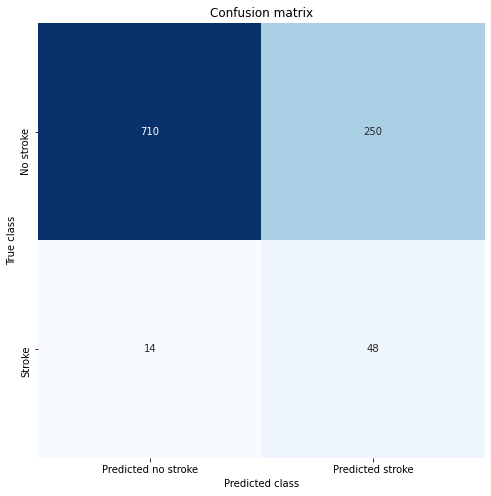

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.16      0.77      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.74      0.81      1022



In [37]:
predictions = log_model.predict(X_test)

matriz_confusion(y_test, predictions)

#### METRICAS

In [38]:
accuracy_log = round(accuracy_score(y_test, predictions), 2)
precision_log = round(precision_score(y_test, predictions), 2)
recall_log = round(recall_score(y_test, predictions), 2)
f1_log = round(f1_score(y_test, predictions), 2)
roc_auc_log = round(roc_auc_score(y_test, predictions), 2)

### RANDOM FOREST

#### MODELO

In [42]:
# RANDOM FOREST

rf = RandomForestClassifier()

parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 4, 5],
    'max_features': [1, 2, 3]
}

clf = GridSearchCV(estimator=rf, param_grid=parameters, n_jobs=-1, cv=10, verbose=2, scoring='roc_auc')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

rf_model = clf.best_estimator_

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'max_depth': 5, 'max_features': 3, 'n_estimators': 300}

Best score: 0.9815548980933595


In [43]:
rf_model.score(X_test, y_test)

0.87573385518591

#### MATRIZ DE CONFUSION

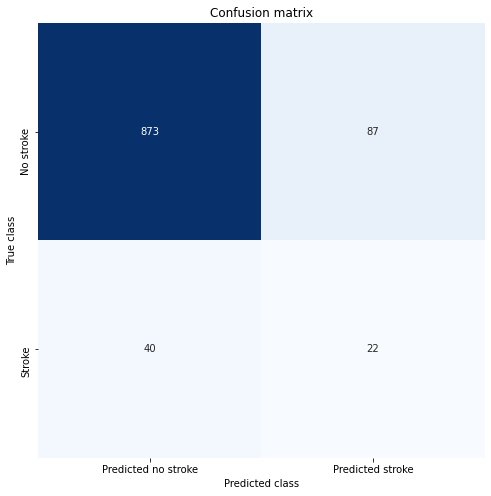

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       960
           1       0.20      0.35      0.26        62

    accuracy                           0.88      1022
   macro avg       0.58      0.63      0.59      1022
weighted avg       0.91      0.88      0.89      1022



In [44]:
predictions = rf_model.predict(X_test)

matriz_confusion(y_test, predictions)

#### METRICAS

In [45]:
accuracy_rf = round(accuracy_score(y_test, predictions), 2)
precision_rf = round(precision_score(y_test, predictions), 2)
recall_rf = round(recall_score(y_test, predictions), 2)
f1_rf = round(f1_score(y_test, predictions), 2)
roc_auc_rf = round(roc_auc_score(y_test, predictions), 2)

### XGBOOST

#### MODELO

In [46]:
# XGBOOST

xgb = XGBClassifier()

parameters = {
    'n_estimators': [140, 150, 160],
    'booster': ['gbtree'],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

clf = GridSearchCV(estimator=xgb, param_grid=parameters, n_jobs=-1, cv=10, verbose=2, scoring='roc_auc')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

xgb_model = clf.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[16:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}

Best score: 0.991611439842209


In [48]:
xgb_model.score(X_test, y_test)

0.9383561643835616

#### MATRIZ DE CONFUSION

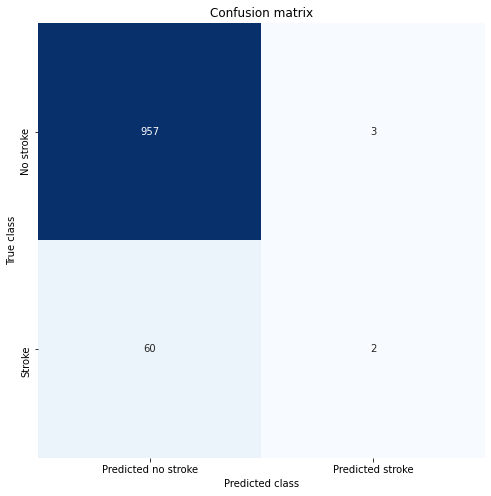

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.40      0.03      0.06        62

    accuracy                           0.94      1022
   macro avg       0.67      0.51      0.51      1022
weighted avg       0.91      0.94      0.91      1022



In [49]:
predictions = xgb_model.predict(X_test)

matriz_confusion(y_test, predictions)

#### METRICAS

In [50]:
accuracy_xgb = round(accuracy_score(y_test, predictions), 2)
precision_xgb = round(precision_score(y_test, predictions), 2)
recall_xgb = round(recall_score(y_test, predictions), 2)
f1_xgb = round(f1_score(y_test, predictions), 2)
roc_auc_xgb = round(roc_auc_score(y_test, predictions), 2)

# RESULTADOS

In [51]:
# CREAR DATAFRAME CON LOS MODELOS Y SUS METRICAS

metricas = pd.DataFrame(columns=['Logistic Regression', 'Random Forest', 'XGBOOST'], index=range(5))

# LOGISTIC REGRESSION

metricas.iloc[0, 0] = accuracy_log
metricas.iloc[1, 0] = precision_log
metricas.iloc[2, 0] = recall_log
metricas.iloc[3, 0] = f1_log
metricas.iloc[4, 0] = roc_auc_log

# RANDOM FOREST

metricas.iloc[0, 1] = accuracy_rf
metricas.iloc[1, 1] = precision_rf
metricas.iloc[2, 1] = recall_rf
metricas.iloc[3, 1] = f1_rf
metricas.iloc[4, 1] = roc_auc_rf

#XGBOOST

metricas.iloc[0, 2] = accuracy_xgb
metricas.iloc[1, 2] = precision_xgb
metricas.iloc[2, 2] = recall_xgb
metricas.iloc[3, 2] = f1_xgb
metricas.iloc[4, 2] = roc_auc_xgb

metricas

,Logistic Regression,Random Forest,XGBOOST
0,0.74,0.88,0.94
1,0.16,0.2,0.4
2,0.77,0.35,0.03
3,0.27,0.26,0.06
4,0.76,0.63,0.51


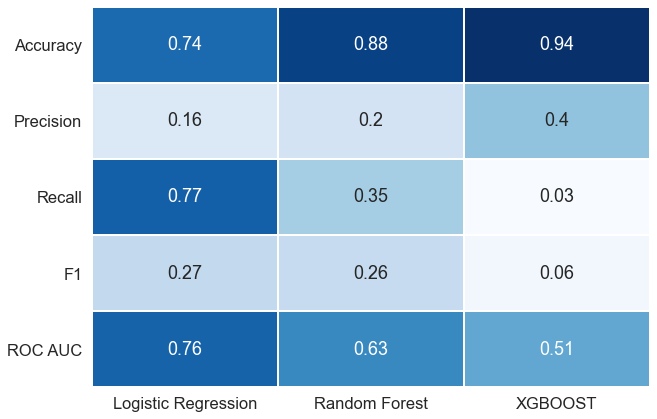

In [54]:
# HEATMAP DATAFRAME METRICAS

plt.figure(figsize = (10, 7))

sns.heatmap(metricas[metricas.columns.to_list()].astype(float),
            cmap = 'Blues',
            annot = True,
            linewidths = 1,
            cbar = False,
            yticklabels = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])

sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()